In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

In [2]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

## Loading and Cleaning the Data

In [3]:
#papers_ = spark.read.option("multiLine", True).option("mode", "PERMISSIVE").option("encoding", "ascii").json("../data/AL_papers.json")
#papers_ = spark.read.option("multiLine", True).option("mode", "PERMISSIVE").option("encoding", "ascii").json("../data/data2/paps1.json")
papers_ = spark.read.option("multiLine", True).option("mode", "PERMISSIVE").option("encoding", "ascii").json("../data/papers/")
papers = papers_.select(explode(col("hits.hits")).alias("paper"))

In [10]:
papers.count()

3000

In [11]:
def ascii_ignore(x):
    return x.encode('ascii', 'ignore').decode('ascii')
ascii_udf = udf(ascii_ignore)


In [12]:
short_papers = papers.select(
    element_at(col("paper.metadata.titles.title"), 1).alias("title"),
    element_at(col("paper.metadata.abstracts.value"), 1).alias("abstract"),
    col("paper.created"), col("paper.metadata.number_of_pages"),
    col("paper.metadata.keywords"), size(
        col("paper.metadata.references")).alias("num_refs"),
    col("paper.metadata.citation_count"),
    col("paper.metadata.authors.full_name").alias("authors")
).withColumn("title", ascii_udf("title"));
short_papers.printSchema()

root
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- created: string (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- schema: string (nullable = true)
 |    |    |-- source: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- num_refs: integer (nullable = false)
 |-- citation_count: long (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Keywords Extraction

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

This is the list of assigned keywords from the whole dataset

In [14]:
kws  = short_papers.select(explode(col("keywords"))).select("col.value").withColumnRenamed("value", "K")
kws.groupby("K").count().sort(desc("count")).show(truncate=False)

+----------------------+-----+
|K                     |count|
+----------------------+-----+
|new physics           |287  |
|CERN LHC Coll         |269  |
|numerical calculations|220  |
|quantum chromodynamics|218  |
|structure             |204  |
|sensitivity           |169  |
|heavy ion: scattering |152  |
|effective field theory|145  |
|lattice               |137  |
|GeV                   |137  |
|stability             |121  |
|quark                 |120  |
|lattice field theory  |119  |
|kinematics            |119  |
|p p: scattering       |119  |
|background            |112  |
|higher-order: 1       |108  |
|dark matter: mass     |100  |
|anomaly               |100  |
|dark matter           |99   |
+----------------------+-----+
only showing top 20 rows



Select 20 most used

In [15]:
# replacing some characters with _
import re
def format_kwd(kwd):
    return re.sub("[\.-/ :()]", "_", kwd)

In [16]:
selected_keywords = kws.groupby("K").count().sort(desc("count")).limit(20).toPandas()["K"].tolist()
selected_keywords = [format_kwd(K) for K in selected_keywords] + ["None"]
selected_keywords

['new_physics',
 'CERN_LHC_Coll',
 'numerical_calculations',
 'quantum_chromodynamics',
 'structure',
 'sensitivity',
 'heavy_ion__scattering',
 'effective_field_theory',
 'lattice',
 'GeV',
 'stability',
 'quark',
 'p_p__scattering',
 'lattice_field_theory',
 'kinematics',
 'background',
 'higher-order__1',
 'dark_matter__mass',
 'anomaly',
 'dark_matter',
 'None']

In [17]:
# from https://www.geeksforgeeks.org/python-intersection-two-lists/
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [18]:
from pyspark.sql.functions import monotonically_increasing_id

Extracting these keywords to a column

In [19]:
# returns first keyword
@udf(returnType=ArrayType(StringType()))
def list_keywords(a):
    return [format_kwd(aa["value"]) for aa in a] if a else ["None"]

@udf(returnType=ArrayType(StringType()))
def filtered_list_keywords(a):
    kws_list = [format_kwd(aa["value"]) for aa in a] if a else ["None"]
    kws_list = intersection(kws_list, selected_keywords)
    return kws_list if kws_list else ["None"]

withKeywords = short_papers.withColumn("keywords_", filtered_list_keywords(col("keywords"))) # .withColumn("id", monotonically_increasing_id())

In [20]:
# Creating dummy variables
from pyspark.sql.functions import array_contains
dummy_df = withKeywords
for kw in selected_keywords:
    dummy_df = dummy_df.withColumn(
        kw.replace(".", "_"), 
        array_contains(col("keywords_"), kw).cast("int")
    )
dummy_df = dummy_df.select( ["title","number_of_pages", "citation_count", "num_refs"] + selected_keywords)
dummy_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- citation_count: long (nullable = true)
 |-- num_refs: integer (nullable = false)
 |-- new_physics: integer (nullable = true)
 |-- CERN_LHC_Coll: integer (nullable = true)
 |-- numerical_calculations: integer (nullable = true)
 |-- quantum_chromodynamics: integer (nullable = true)
 |-- structure: integer (nullable = true)
 |-- sensitivity: integer (nullable = true)
 |-- heavy_ion__scattering: integer (nullable = true)
 |-- effective_field_theory: integer (nullable = true)
 |-- lattice: integer (nullable = true)
 |-- GeV: integer (nullable = true)
 |-- stability: integer (nullable = true)
 |-- quark: integer (nullable = true)
 |-- p_p__scattering: integer (nullable = true)
 |-- lattice_field_theory: integer (nullable = true)
 |-- kinematics: integer (nullable = true)
 |-- background: integer (nullable = true)
 |-- higher-order__1: integer (nullable = true)
 |-- dark_matter__mass: integer (nullable

In [21]:
dummy_df.write.mode("overwrite").json("../data/processed/dummy.json")

In [ ]:
dummy_df.take(

## Clustering

### Our Data (THIS DOES NOT WORK CURRENTLY, TRY TO RUN kmeans_clustering NOTEBOOK)

In [21]:

paps = dummy_df

In [22]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())

In [30]:
# dropping nans
papersWIDs_woNA = papersWIDs.dropna()
print( [papersWIDs.count(), papersWIDs_woNA.count()])

[250, 245]


In [31]:
# feature columns (all but title and id)
cols = [c for c in papersWIDs_woNA.columns if not c in ["title", "id"]]
cols

['number_of_pages',
 'num_refs',
 'CERN_LHC_Coll',
 'new_physics',
 'quantum_chromodynamics',
 'GeV',
 'structure',
 'lattice',
 'effective_field_theory',
 'cosmological_model',
 'numerical_calculations',
 'quark',
 'p_p__scattering',
 'lattice_field_theory',
 'kinematics',
 'sensitivity',
 'stability',
 'dark_matter',
 'quantum_chromodynamics__perturbation_theory',
 'equation_of_state',
 'chiral',
 'tree_approximation',
 'None']

In [33]:
# assembling features
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler().setInputCols(cols).setOutputCol("features")
transformed_data = assembler.transform(papersWIDs_woNA)

In [34]:
# noramalizaing the data
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scale_model  = scaler.fit(transformed_data)
scaled_data = scale_model.transform(transformed_data)

In [35]:
# finding optimal clusters number
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
metric_name = 'silhouette'
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName=metric_name, distanceMeasure='squaredEuclidean')
scores = []
for i in range(2, 20):
    kmeans_algo = KMeans(featuresCol="scaledFeatures", k=i)
    kmeans_fit = kmeans_algo.fit(scaled_data)
    kmeans_out = kmeans_fit.transform(scaled_data)
    score = evaluator.evaluate(kmeans_out)
    print(score)
    scores.append(score)

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 43198)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 480, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 503, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/socketserver.py", line 316, in _handle_request

Py4JError: An error occurred while calling o537.fit

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 480, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 503, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [ ]:
selected_keywords[-2:]

['tree_approximation', 'None']

In [ ]:
assembler = VectorAssembler().setInputCols(dummy_df.columns[-18:]).setOutputCol("features")
data_transformed = assembler.transform(dummy_df.limit(100))

kmean = KMeans().setK(4).setSeed(1).setFeaturesCol("features")
model = kmean.fit(data_transformed)

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
preds = model.transform(data_transformed)
preds.select("title", "prediction")

title,prediction
Shadow Extra Dime...,0
Critical behavior...,0
Investigation of ...,2
Meson structure o...,0
Improving heavy D...,2
Coupled-channel a...,0
Revisiting the co...,2
Electroweak Radia...,3
Heavy Higgs boson...,3
Gluon fragmentati...,0


<AxesSubplot:>

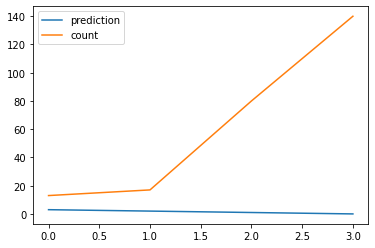

In [ ]:
preds.select("prediction").groupby("prediction").count().sort("count").toPandas().plot()

In [ ]:
evaluator = ClusteringEvaluator()
evaluator.setPredictionCol("prediction")

ClusteringEvaluator_2e7273e2f3f8

In [ ]:
import numpy as np

In [ ]:
metric = []
for k in range(5, 10):
    print(k)
    kmean = KMeans().setK(k).setFeaturesCol("features")
    model = kmean.fit(data_transformed)
    preds = model.transform(data_transformed)
    metric = metric + [evaluator.evaluate(preds)]

5


ConnectionRefusedError: [Errno 111] Connection refused

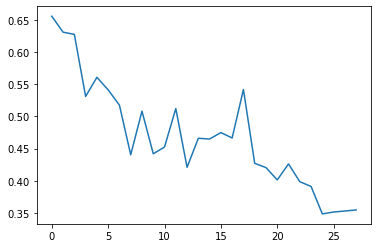

In [ ]:
plt.plot(metric)

In [ ]:
kmean = KMeans().setK(10).setFeaturesCol("features")
model = kmean.fit(data_transformed)
preds = model.transform(data_transformed)
evaluator.evaluate(preds)

0.5081599677100584

### Papers

### Some example from https://runawayhorse001.github.io/LearningApacheSpark/clustering.html

https://stackoverflow.com/questions/44152337/hierarchical-agglomerative-clustering-in-spark

Reading and casting IRIS dataset

In [ ]:
dataset = spark.read.option("header", True).csv("../data/iris.csv").\
    withColumnRenamed("sepal.length", "SL").\
    withColumnRenamed("sepal.width", "SW").\
    withColumnRenamed("petal.length", "PL").\
    withColumnRenamed("petal.width", "PW").\
    select( 
        col("SL").cast("float"),
        col("SW").cast("float"),
        col("PL").cast("float"),
        col("PW").cast("float"),
        col("variety")
    )
dataset.printSchema()

root
 |-- SL: float (nullable = true)
 |-- SW: float (nullable = true)
 |-- PL: float (nullable = true)
 |-- PW: float (nullable = true)
 |-- variety: string (nullable = true)



In [ ]:
assembler = VectorAssembler().setInputCols(["SL", "SW", "PL", "PW"]).setOutputCol("features")
data_transformed = assembler.transform(dataset)
data_transformed

SL,SW,PL,PW,variety,features
5.1,3.5,1.4,0.2,Setosa,[5.09999990463256...
4.9,3.0,1.4,0.2,Setosa,[4.90000009536743...
4.7,3.2,1.3,0.2,Setosa,[4.69999980926513...
4.6,3.1,1.5,0.2,Setosa,[4.59999990463256...
5.0,3.6,1.4,0.2,Setosa,"[5.0,3.5999999046..."
5.4,3.9,1.7,0.4,Setosa,[5.40000009536743...
4.6,3.4,1.4,0.3,Setosa,[4.59999990463256...
5.0,3.4,1.5,0.2,Setosa,"[5.0,3.4000000953..."
4.4,2.9,1.4,0.2,Setosa,[4.40000009536743...
4.9,3.1,1.5,0.1,Setosa,[4.90000009536743...


In [ ]:
data_transformed.select("variety").distinct()

variety
Virginica
Setosa
Versicolor


In [ ]:
bkm = BisectingKMeans().setK(3).setSeed(1).setFeaturesCol("features")
kmean = KMeans().setK(3).setSeed(1).setFeaturesCol("features")
model = kmean.fit(data_transformed)

In [ ]:
model.clusterCenters()

[array([5.9016129 , 2.74838711, 4.39354837, 1.43387096]),
 array([5.006     , 3.42800001, 1.462     , 0.246     ]),
 array([6.84999998, 3.0736842 , 5.74210525, 2.07105261])]

In [ ]:
preds = model.transform(data_transformed)

In [ ]:
preds_ = preds.select("SL", "SW", "PL", "PW", "variety", "prediction").toPandas()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='PL', ylabel='PW'>

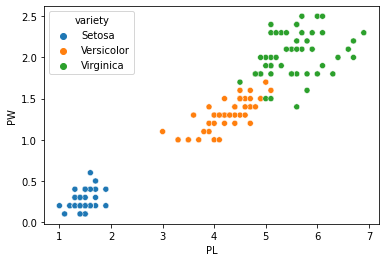

In [ ]:
sns.scatterplot(data = preds_, x="PL", y="PW", hue="variety")

<AxesSubplot:xlabel='PL', ylabel='PW'>

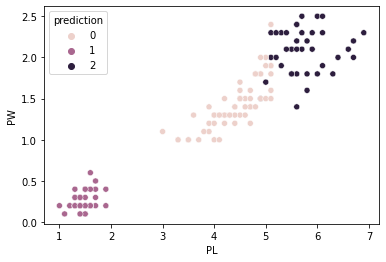

In [ ]:
sns.scatterplot(data = preds_, x="PL", y="PW", hue="prediction")

In [ ]:
preds_.columns

Index(['SL', 'SW', 'PL', 'PW', 'variety', 'prediction'], dtype='object')

In [ ]:
preds.groupby("variety", "prediction").count().sort(desc("count"))

variety,prediction,count
Setosa,1,50
Versicolor,0,48
Virginica,2,36
Virginica,0,14
Versicolor,2,2


In [ ]:
from pyspark.ml.clustering import 